# 01 Chainerの基本的な使い方を学んでみよう

このNotebookの目的は以下の通りです。

* 畳み込みニューラルネットワークについて学習すること
* Chainerの機能について学習すること


## ColaboratoryでChainerを使うための設定

### 必要なライブラリ・Chainer・CuPyのインストール

下記のスクリプト内では、GPUを動かすのに必要なパッケージのインストール、Chainerのインストール、cudaのバージョンに応じたCuPyのインストールが行われています。

本来なら適切なバージョンの**CuPyをインストールする必要があります。**しかし、上記スクリプトはColaboratoryにインストールされているcudaのバージョンを見て、自動的に適切なCuPyをインストールします。

In [1]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1379  100  1379    0     0   6629      0 --:--:-- --:--:-- --:--:--  6598
+ apt -y -q install cuda-libraries-dev-9-2
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  cuda-cublas-dev-9-2 cuda-cufft-dev-9-2 cuda-curand-dev-9-2
  cuda-cusolver-dev-9-2 cuda-cusparse-dev-9-2 cuda-npp-dev-9-2
  cuda-nvgraph-dev-9-2 cuda-nvrtc-dev-9-2
The following NEW packages will be installed:
  cuda-cublas-dev-9-2 cuda-cufft-dev-9-2 cuda-curand-dev-9-2
  cuda-cusolver-dev-9-2 cuda-cusparse-dev-9-2 cuda-libraries-dev-9-2
  cuda-npp-dev-9-2 cuda-nvgraph-dev-9-2 cuda-nvrtc-dev-9-2
0 upgraded, 9 newly installed, 0 to remove and 5 not upgraded.
Need to get 332 MB of archives.
After this operation, 972 MB of additional disk space will be used.
Get:1 https://develop

Chainer v4.0.0から`chainer.print_runtime_info()`という便利なメソッドが追加されました。以下のコマンドをターミナルで実行し、ChainerやCuPyが正しくインストールされたかを確認してみましょう。

In [2]:
!python -c 'import chainer; chainer.print_runtime_info()'

Platform: Linux-4.14.65+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 5.0.0
NumPy: 1.14.6
CuPy:
  CuPy Version          : 5.0.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 9020
  CUDA Driver Version   : 9020
  CUDA Runtime Version  : 9020
  cuDNN Build Version   : 7201
  cuDNN Version         : 7201
  NCCL Build Version    : 2213
iDeep: Not Available


うまくインストールできていますね。以下のチュートリアルでは、matplotlibを可視化に使いますので、これも同時にインストールしておきましょう。

In [0]:
!apt -y -qq install graphviz > /dev/null 2> /dev/null
!pip install pydot

In [0]:
!pip install chutil

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import chainer
import chutil

## 畳み込みニューラルネットワーク (前回の復習)



[LeNet5](http://yann.lecun.com/exdb/lenet/)をシンプルにしたモデルを以下に示します。このモデルは、3つの畳み込み(convolution)層と、2つの全結合層を持つ計5層のネットワークです。

- これを元に以下の条件で精度90%以上を達成しましょう。

    1. エポック数30以下
    2. 訓練時間200秒以内

![LeNet-5 architecture as published in [1]](https://cdn-images-1.medium.com/max/2000/1*1TI1aGBZ4dybR6__DI9dzA.png)
LeNet-5 architecture as published in [1]

```python
class LeNet5(Chain):
    def __init__(self):
        super(LeNet5, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(
                in_channels=1, out_channels=6, ksize=5, stride=1, pad=0)
            self.conv2 = L.Convolution2D(
                in_channels=6, out_channels=16, ksize=5, stride=1, pad=0)
            self.conv3 = L.Convolution2D(
                in_channels=16, out_channels=120, ksize=4, stride=1, pad=0)
            self.fc4 = L.Linear(None, 84)
            self.fc5 = L.Linear(84, 10)

    def __call__(self, x):
        h = F.sigmoid(self.conv1(x.reshape((-1, 1, 28, 28))))
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.sigmoid(self.conv2(h))
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.sigmoid(self.conv3(h))
        h = F.sigmoid(self.fc4(h))
        return self.fc5(h)
```



そもそも、ここでは初めて紹介することになる層があると思います。まずはこれらについて説明します。

* 畳み込み層 (`L.Convolution2D`)
* プーリング層 (`F.max_pooling_2d`)

### 2次元畳み込み層 (`L.Convolution2D`)
畳み込み層とは、入力データに対して[畳み込み](https://ja.wikipedia.org/wiki/%E7%95%B3%E3%81%BF%E8%BE%BC%E3%81%BF)演算を行う層のことです。今回は画像に適用するということで、特に2次元の場合について説明します。

畳み込み層に使用される主なパラメータとして、以下が存在します。

* フィルターサイズ  `ksize`：フィルターの長さのこと
* ストライド `stride`：フィルターの適用間隔のこと
* パッディングサイズ `pad`：周辺を0で埋める長さのこと

言葉で説明するよりは画像を利用したほうが直感的に理解できると思うので、
例えば以下の場合についてgif画像[2]を利用して説明します。

1. フィルターサイズ  `ksize=3`、ストライド `stride=1`、パッディングサイズ `pad=0`
2. フィルターサイズ  `ksize=3`、ストライド `stride=2`、パッディングサイズ `pad=0`
3. フィルターサイズ  `ksize=3`、ストライド `stride=1`、パッディングサイズ `pad=1`




1についてですが、フィルターサイズ  `ksize=3`とあるように、平行移動しているフィルターの長さが3になっています。

![no_padding_no_strides](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif)

2についてですが、1に対してストライド `stride=2`と変化しています。そのため、フィルターの長さに変化はありませんが、入力データに対して2個おきにフィルターを適用しています。

![no_padding_strides](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_strides.gif)

3についてですが、1に対してパッディングサイズ `pad=1`と変化しています。そのため、フィルターの長さに変化はありませんが、周囲を1つ穴埋めした入力データに対してフィルターを適用しています。

![same_padding_no_strides](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/same_padding_no_strides.gif)

おそらくお気づきになったと思いますが、上記のパラメータによって入力データと出力データのサイズが変化します。入力データのサイズを$L_i$、出力データのサイズを$L_o$とした時以下の関係があります。

$$
L_o = (L_i + 2 * pad - ksize) / stride + 1
$$

そもそもなぜこのような畳み込み処理を画像に適用するのでしょうか。

実は画像処理では、古くから畳み込み処理により平滑化やエッジ抽出を行ってきました。
例えば、ラプラシアンフィルタは以下のようにエッジ抽出の効果があります。

![laplacian filter](https://raw.githubusercontent.com/chainer-community/chainer-colab-notebook/master/docs/images/laplacian_filter.png)

もし、フィルターサイズ ksize=3のフィルタが以下だった場合、

$$
\begin{bmatrix}
1 & 1 & 1 \\
1 & -8 & 1 \\
1 & 1 & 1 \\
\end{bmatrix}
$$

畳み込み層も同様の役割を持つでしょう。


WikipediaのKernel_(image_processing)の項目には、他のフィルターも紹介されていますので御覧ください。

#### 課題
- 上記のパラメータ以外にも、`dilate`というパラメータがあります。以下のように、飛び飛びにフィルターを適用します。この時、入力データのサイズ𝐿𝑖 と出力データのサイズ𝐿𝑜の間で、どのような等式が成り立つでしょうか。

![no_padding_no_strides](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/dilation.gif)

### プーリング層 (`F.max_pooling_2d`)
プーリング層は、ダウンサンプルを行う層です。こちらも画像の場合なので、特に2次元の場合を説明します。

プーリング層も、畳み込み層と同様のパラメータを持ちます。

* フィルターサイズ  `ksize`：フィルターの長さのこと
* ストライド `stride`：フィルターの適用間隔のこと
* パッディングサイズ `pad`：周辺を0で埋める長さのこと


`F.max_pooling_2d`の場合、フィルター適用範囲の最大値を結果として出力します。

![max pooling](https://raw.githubusercontent.com/chainer-community/chainer-colab-notebook/master/docs/images/max_pooling.png)

他のプーリング層は[Reference](https://docs.chainer.org/en/stable/reference/functions.html#spatial-pooling)を参照ください。

### 前回の課題に挑戦
前回の繰り返しにはなりますが、データセットのダウンロードと、訓練のための関数`train_and_validate`を定義します。

In [0]:
from chainer.datasets.fashion_mnist import get_fashion_mnist

# データセットがダウンロード済みでなければ、ダウンロードも行う
train, test = get_fashion_mnist(withlabel=True, ndim=1)
train, validation = chainer.datasets.split_dataset_random(train, 50000, seed=0)

In [0]:
from chainer import optimizers, training
from chainer.training import extensions

def  train_and_validate(
        model, optimizer, train, validation, n_epoch, batchsize, device=0):
    
    # 1. deviceがgpuであれば、gpuにモデルのデータを転送する
    if device >= 0:
        model.to_gpu(device)
        
    # 2. Optimizerを設定する
    optimizer.setup(model)
    
    # 3. DatasetからIteratorを作成する
    train_iter = chainer.iterators.SerialIterator(train, batchsize)
    validation_iter = chainer.iterators.SerialIterator(
        validation, batchsize, repeat=False, shuffle=False)
    
    # 4. Updater・Trainerを作成する
    updater = training.StandardUpdater(train_iter, optimizer, device=device)
    trainer = chainer.training.Trainer(updater, (n_epoch, 'epoch'), out='out')
    
    # 5. Trainerの機能を拡張する
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.Evaluator(validation_iter, model, device=device), name='val')
    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(
        ['main/loss', 'val/main/loss'],x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(
        ['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
    trainer.extend(extensions.dump_graph('main/loss'))
    
    # 6. 訓練を開始する
    trainer.run()

それでは、`LeNet5`にいくつかの変更を加えた`MyConvNet`を定義して、訓練とテストを行ってみましょう。変更点はコメントにあるように以下の通りです。

* 各convolution層のチャネル数、ノード数を増やす
* 各convolution層のフィルター数`ksize=3`, ストライド`stride=3`、パッディング`pad=1`に変更
* convolution層を1層(`conv4`)追加
* 活性化関数を`ReLU`に変更


In [0]:
import chainer.functions as F
import chainer.links as L
from chainer import Chain

class MyConvNet(Chain):
    def __init__(self):
        super(MyConvNet, self).__init__()
        with self.init_scope():
            # all pads are 0 -> 1
            self.conv1 = L.Convolution2D(
                in_channels=None, out_channels=32, ksize=3, stride=1, pad=1)  # 6 -> 32
            self.conv2 = L.Convolution2D(
                in_channels=None, out_channels=64, ksize=3, stride=1, pad=1) # 16 -> 64
            self.conv3 = L.Convolution2D(
                in_channels=None, out_channels=128, ksize=3, stride=1, pad=1) # 120 -> 128
            self.conv4 = L.Convolution2D(
                in_channels=None, out_channels=128, ksize=3, stride=1, pad=1) # new layer
            self.fc5 = L.Linear(None, 1000) # 84 -> 1000
            self.fc6 = L.Linear(None, 10)

    def __call__(self, x):
        h = F.relu(self.conv1(x.reshape((-1, 1, 28, 28))))
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.relu(self.conv2(h))  # sigmoid -> relu
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.relu(self.conv3(h))  # sigmoid -> relu
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.relu(self.conv4(h))  # sigmoid -> relu
        h = F.relu(self.fc5(h))  # sigmoid -> relu
        return self.fc6(h)

In [0]:
enable_cupy = True
n_epoch = 1
n_epoch = 20
batchsize = 128

model = MyConvNet()
classifier_model = L.Classifier(model)
optimizer = optimizers.Adam()
train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, batchsize)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           0.456159    0.832641       0.312037       0.888746           17.3382       
2           0.278835    0.897878       0.26679        0.898833           26.5215       
3           0.232103    0.913602       0.249188       0.908821           35.7338       
4           0.199529    0.925591       0.233135       0.914854           44.999        
5           0.174546    0.934902       0.219428       0.920194           54.2181       
6           0.152604    0.942528       0.230984       0.914656           63.4593       
7           0.129838    0.950687       0.229853       0.923853           72.9093       
8           0.110952    0.958093       0.244535       0.915744           82.2808       
9           0.096541    0.963555       0.257145       0.921084           91.3895       
10          0.0812234   0.969949       0.268991       0.921381           100.528       
11          0.0699633   0.973157  

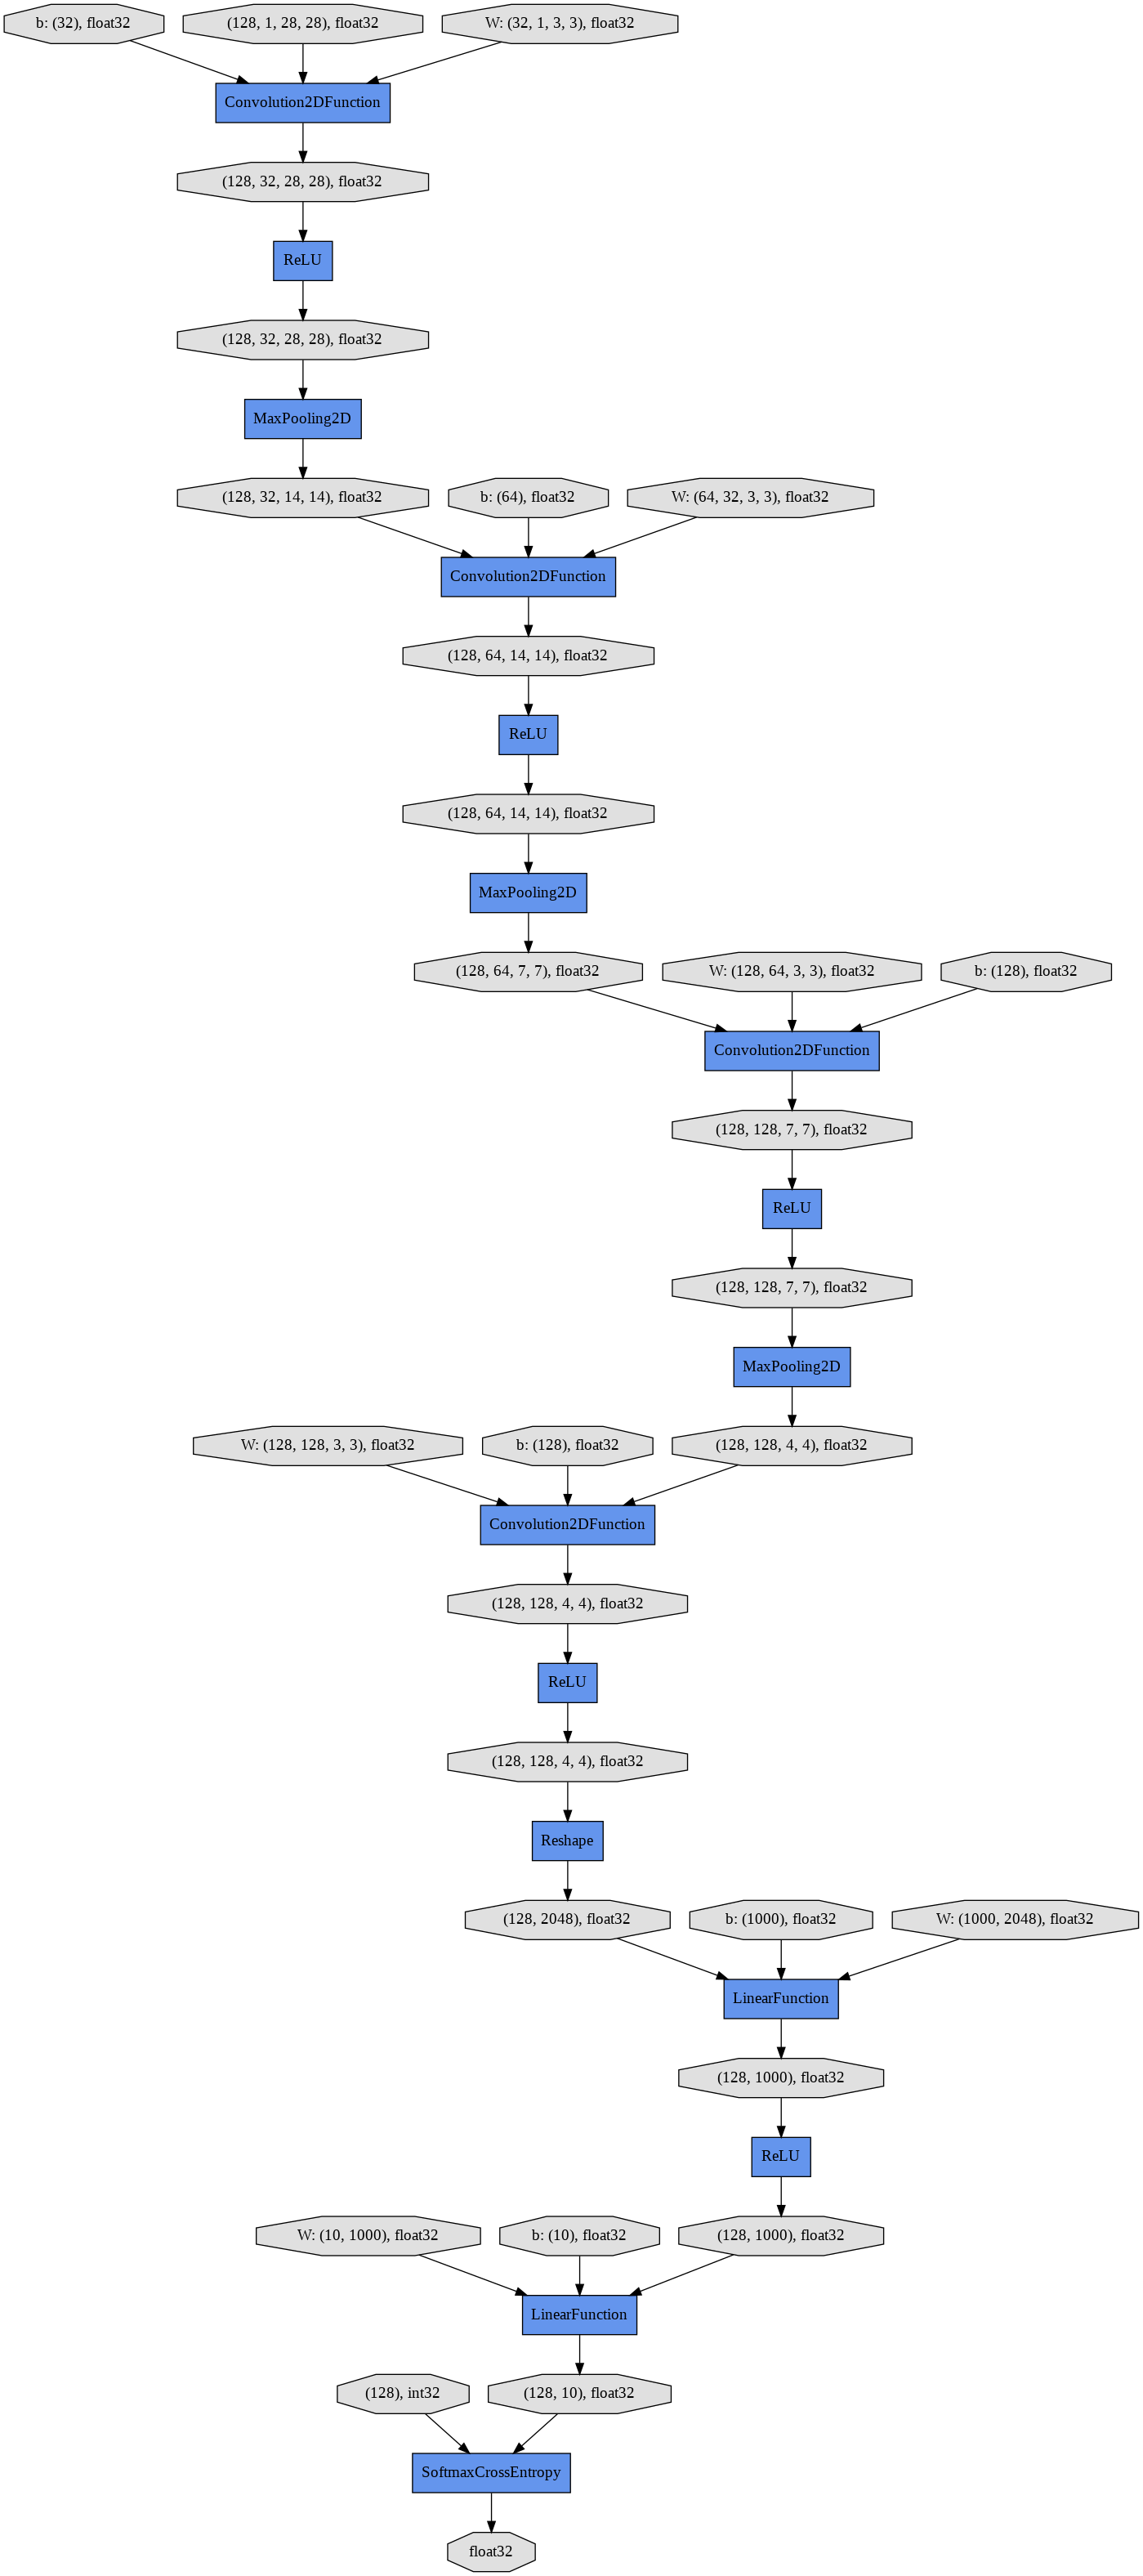

In [0]:
from chutil.visualize.show import show_graph

show_graph()

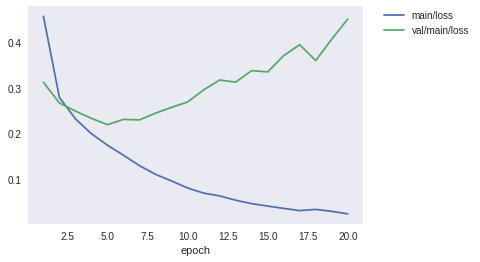

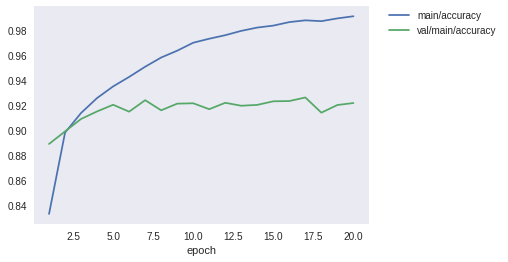

In [0]:
from chutil.visualize.show import show_loss_and_accuracy

show_loss_and_accuracy()

In [0]:
from chutil.visualize.show import show_test_performance

show_test_performance(classifier_model, test)

Test accuracy: 0.91982424


In [0]:
class MyConvNet(Chain):
    def __init__(self):
        super(MyConvNet, self).__init__()
        with self.init_scope():
            # all pads are 0 -> 1
            self.conv1 = L.Convolution2D(
                in_channels=None, out_channels=32, ksize=3, stride=1, pad=1)
            self.conv2 = L.Convolution2D(
                in_channels=None, out_channels=64, ksize=3, stride=1, pad=1)
            self.conv3 = L.Convolution2D(
                in_channels=None, out_channels=128, ksize=3, stride=1, pad=1)
            self.conv4 = L.Convolution2D(
                in_channels=None, out_channels=128, ksize=3, stride=1, pad=1)
            self.fc5 = L.Linear(None, 2000) # 1000 -> 2000
            self.fc6 = L.Linear(None, 10)

    def __call__(self, x):
        h = F.dropout(F.relu(self.conv1(x.reshape((-1, 1, 28, 28)))), ratio=0.2)  # add dropout
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.dropout(F.relu(self.conv2(h)), ratio=0.2)  # add dropout
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.dropout(F.relu(self.conv3(h)), ratio=0.2)  # add dropout
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.dropout(F.relu(self.conv4(h)))  # add dropout
        h = F.dropout(F.relu(self.fc5(h)))  # add dropout
        return self.fc6(h)

In [0]:
enable_cupy = True
n_epoch = 20
batchsize = 128

model = MyConvNet()
classifier_model = L.Classifier(model)
optimizer = optimizers.Adam()
train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, batchsize)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           0.553697    0.794977       0.387361       0.86254            10.9894       
2           0.352021    0.870724       0.343159       0.873418           21.6753       
3           0.299985    0.88756        0.281276       0.900218           32.2488       
4           0.270547    0.901894       0.265802       0.902591           42.9115       
5           0.256918    0.90643        0.245724       0.911887           53.5615       
6           0.240187    0.910557       0.24804        0.910008           64.0522       
7           0.225157    0.91652        0.223051       0.918315           74.6426       
8           0.216988    0.91867        0.227083       0.914953           85.1441       
9           0.207234    0.923813       0.216907       0.920293           95.6334       
10          0.199658    0.925492       0.217243       0.917227           106.077       
11          0.196208    0.926382  

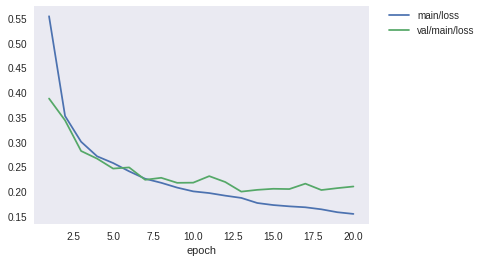

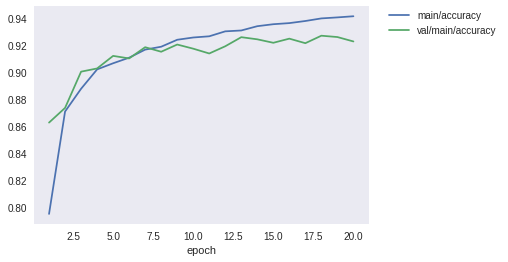

In [0]:
show_loss_and_accuracy()

In [0]:
show_test_performance(classifier_model, test)

Test accuracy: 0.92275393


## Chainerの機能

前回、今回のハンズオンでは、下記の関数`train_and_validate`を使用してきました。
ここでは、その関数の中身について解説していきます。

```python
def  train_and_validate(
        model, optimizer, train, validation, n_epoch, enable_cupy, batchsize):
    
    # 1. cpu/gpuを決める
    device = -1
    if enable_cupy:
        device = 0
        chainer.backends.cuda.get_device_from_id(device).use()
        model.to_gpu()
        
    # 2. Optimizerを設定する
    optimizer.setup(model)
    
    # 3. DatasetからIteratorを作成する
    train_iter = chainer.iterators.SerialIterator(train, batchsize)
    validation_iter = chainer.iterators.SerialIterator(
        validation, batchsize, repeat=False, shuffle=False)
    
    # 4. Updater・Trainerを作成する
    updater = training.StandardUpdater(train_iter, optimizer, device=device)
    trainer = chainer.training.Trainer(updater, (n_epoch, 'epoch'), out='out')
    
    # 5. Trainerの機能を拡張する
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.Evaluator(validation_iter, model, device=device), name='val')
    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(
        ['main/loss', 'val/main/loss'],x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(
        ['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
    trainer.extend(extensions.dump_graph('main/loss'))
    
    # 6. 訓練を開始する
    trainer.run()
```

### 2. Iteratorの作成

データセットの準備は完了しましたが、このままネットワークの学習に使うのは少し面倒です。なぜなら、ネットワークのパラメータ最適化手法として広く用いられているStochastic Gradient Descent (SGD)という手法では、一般的にいくつかのデータを束ねた**ミニバッチ**と呼ばれる単位でネットワークにデータを渡し、それに対する予測を作って、ラベルと比較するということを行います。そのため、**バッチサイズ分だけデータとラベルを束ねる作業が必要です。**

そこで、**データセットから決まった数のデータとラベルを取得し、それらを束ねてミニバッチを作ってくれる機能を持った`Iterator`を使いましょう。**`Iterator`は、先程作ったデータセットオブジェクトを渡して初期化してやったあとは、`next()`メソッドで新しいミニバッチを返してくれます。内部ではデータセットを何周なめたか（`epoch`）などの情報がどうように記録されているおり、学習ループを書いていく際に便利です。

データセットオブジェクトからイテレータを作るには、以下のようにします。

ここでは、学習に用いるデータセット用のイテレータ（`train_iter`）と、検証用のデータセット用のイテレータ（`valid_iter`）、および学習したネットワークの評価に用いるテストデータセット用のイテレータ（`test_iter`）の計3つを作成しています。ここで、`batchsize = 128`としているので、作成した3つの`Iterator`は、例えば`train_iter.next()`などとすると128枚の数字画像データを一括りにして返してくれます。

#### NOTE: `SerialIterator`について

Chainerがいくつか用意している`Iterator`の一種である`SerialIterator`は、データセットの中のデータを順番に取り出してくる最もシンプルな`Iterator`です。コンストラクタの引数にデータセットオブジェクトと、バッチサイズを取ります。このとき、渡したデータセットオブジェクトから、何周も何周もデータを繰り返し読み出す必要がある場合は`repeat`引数を`True`とし、1周が終わったらそれ以上データを取り出したくない場合はこれを`False`とします。これは、主にvalidation用のデータセットに対して使うフラグです。デフォルトでは、`True`になっています。また、`shuffle`引数に`True`を渡すと、データセットから取り出されてくるデータの順番をエポックごとにランダムに変更します。`SerialIterator`の他にも、マルチプロセスで高速にデータを処理できるようにした`MultiprocessIterator`や`MultithreadIterator`など、複数の`Iterator`が用意されています。詳しくは以下を見てください。

- [Chainerで使えるIterator一覧](https://docs.chainer.org/en/stable/reference/iterators.html)

### 3. 最適化手法の選択

では、上で定義したネットワークをMNISTデータセットを使って訓練してみましょう。学習時に用いる最適化の手法としてはいろいろな種類のものが提案されていますが、Chainerは多くの手法を同一のインターフェースで利用できるよう、`Optimizer`という機能でそれらを提供しています。`chainer.optimizers`モジュール以下に色々なものを見つけることができます。一覧はこちらにあります：

- [Chainerで使える最適化手法一覧](https://docs.chainer.org/en/stable/reference/optimizers.html)

ここでは最もシンプルな勾配降下法の手法である`optimizers.SGD`を用います。`Optimizer`のオブジェクトには、`setup`メソッドを使ってモデル（`Chain`オブジェクト）を渡します。こうすることで`Optimizer`に、何を最適化すればいいか把握させることができます。

他にもいろいろな最適化手法が手軽に試せるので、色々と試してみて結果の変化を見てみてください。例えば、下の`chainer.optimizers.SGD`のうち`SGD`の部分を`MomentumSGD`, `RMSprop`,  `Adam`などに変えるだけで、最適化手法の違いがどのような学習曲線（ロスカーブ）の違いを生むかなどを簡単に調べることができます。

#### NOTE

今回はSGDのコンストラクタの`lr`という引数に $0.01$ を与えました。この値は学習率として知られ、モデルをうまく訓練して良いパフォーマンスを発揮させるために調整する必要がある重要な**ハイパーパラメータ**として知られています。

### 2. Updaterの準備

ここからが学習ループを自分で書く場合と異なる部分です。ループを自分で書く場合には、データセットからバッチサイズ分のデータをとってきてミニバッチに束ねて、それをネットワークに入力して予測を作り、それを正解と比較し、ロスを計算してバックワード（誤差逆伝播）をして、`Optimizer`によってパラメータを更新する、というところまでを、以下のように書いていました。

```python
# ---------- 学習の1イテレーション ----------
train_batch = train_iter.next()
x, t = concat_examples(train_batch, gpu_id)

# 予測値の計算
y = net(x)

# ロスの計算
loss = F.softmax_cross_entropy(y, t)

# 勾配の計算
net.cleargrads()
loss.backward()

# パラメータの更新
optimizer.update()
```

これらの処理を、まるっと`Updater`はまとめてくれます。これを行うために、**`Updater`には`Iterator`と`Optimizer`を渡してやります。** `Iterator`はデータセットオブジェクトを持っていて、そこからミニバッチを作り、`Optimizer`は最適化対象のネットワークを持っていて、それを使って前進計算とロスの計算・パラメータのアップデートをすることができます。そのため、この2つを渡しておけば、上記の処理を`Updater`内で全部行ってもらえるというわけです。では、`Updater`オブジェクトを作成してみましょう。

#### NOTE

ここでは、ネットワークを`L.Classifier`で包んでいます。`L.Classifier`は一種の`Chain`になっていて、渡されたネットワーク自体を`predictor`というattributeに持ち、**ロス計算を行う機能を追加してくれます。**こうすると、`net()`はデータ`x`だけでなくラベル`t`も取るようになり、まず渡されたデータを`predictor`に通して予測を作り、それを`t`と比較して**ロスの`Variable`を返すようになります。**ロス関数として何を用いるかはデフォルトでは`F.softmax_cross_entropy`となっていますが、`L.Classifier`の引数`lossfunc`にロス計算を行う関数を渡してやれば変更することができるため、Classifierという名前ながら回帰問題などのロス計算機能の追加にも使うことができます。（`L.Classifier(net, lossfun=L.mean_squared_error, compute_accuracy=False)`のようにする）

`StandardUpdater`は前述のような`Updater`の担当する処理を遂行するための最もシンプルなクラスです。この他にも複数のGPUを用いるための`ParallelUpdater`などが用意されています。

### 3. Trainerの準備

実際に学習ループ部分を隠蔽しているのは`Updater`なので、これがあればもう学習を始められそうですが、`Trainer`はさらに`Updater`を受け取って学習全体の管理を行う機能を提供しています。例えば、**データセットを何周したら学習を終了するか(stop_trigger)** や、**途中のロスの値をどのファイルに保存したいか**、**ロスカーブを可視化した画像ファイルを保存するかどうか**など、学習全体の設定として必須・もしくはあると便利な色々な機能を提供しています。

必須なものとしては学習終了のタイミングを指定する`stop_trigger`がありますが、これは`Trainer`オブジェクトを作成するときのコンストラクタで指定します。指定の方法は単純で、`(長さ, 単位)`という形のタプルを与えればよいだけです。「長さ」には数字を、「単位」には`'iteration'`もしくは`'epoch'`のいずれかの文字列を指定します。こうすると、たとえば100 epoch（データセット100周）で学習を終了してください、とか、1000 iteration（1000回更新）で学習を終了してください、といったことが指定できます。`Trainer`を作るときに、`stop_trigger`を指定しないと、学習は自動的には止まりません。

では、実際に`Trainer`オブジェクトを作ってみましょう。

`out`引数では、この次に説明する`Extension`を使って、ログファイルやロスの変化の過程を描画したグラフの画像ファイルなどを保存するディレクトリを指定しています。

Trainerと、その内側にあるいろいろなオブジェクトの関係は、図にまとめると以下のようになっています。このイメージを持っておくと自分で部分的に改造したりする際に便利だと思います。

![image](https://qiita-image-store.s3.amazonaws.com/0/17934/a751df31-b999-f692-d839-488c26b1c48a.png)

### 4. TrainerにExtensionを追加する

`Trainer`を使う利点として、

- ログを自動的にファイルに保存（`LogReport`)
- ターミナルに定期的にロスなどの情報を表示（`PrintReport`）
- ロスを定期的にグラフで可視化して画像として保存（`PlotReport`)
- 定期的にモデルやOptimizerの状態を自動シリアライズ（`snapshot`）
- 学習の進捗を示すプログレスバーを表示（`ProgressBar`）
- ネットワークの構造をGraphvizのdot形式で保存（`dump_graph`）
- ネットワークのパラメータの平均や分散などの統計情報を出力（`ParameterStatistics`）

などなどの様々な便利な機能を簡単に利用することができる点があります。これらの機能を利用するには、`Trainer`オブジェクトに対して`extend`メソッドを使って追加したい`Extension`のオブジェクトを渡してやるだけです。では実際に幾つかの`Extension`を追加してみましょう。

#### `LogReport`

`epoch`や`iteration`ごとの`loss`, `accuracy`などを自動的に集計し、`Trainer`の`out`引数で指定した出力ディレクトリに`log`というファイル名で保存します。

#### `snapshot`

`Trainer`の`out`引数で指定した出力ディレクトリに`Trainer`オブジェクトを指定されたタイミング（デフォルトでは1エポックごと）に保存します。`Trainer`オブジェクトは上述のように`Updater`を持っており、この中に`Optimizer`とモデルが保持されているため、この`Extension`でスナップショットをとっておけば、学習の復帰や学習済みモデルを使った推論などが学習終了後にも可能になります。

#### `dump_graph`

指定された`Variable`オブジェクトから辿れる計算グラフをGraphvizのdot形式で保存します。保存先は`Trainer`の`out`引数で指定した出力ディレクトリです。

#### `Evaluator`

評価用のデータセットの`Iterator`と、学習に使うモデルのオブジェクトを渡しておくことで、学習中のモデルを指定されたタイミングで評価用データセットを用いて評価します。内部では、`chainer.config.using_config('train', False)`が自動的に行われます。`backprop_enable`を`False`にすることは行われないため、メモリ使用効率はデフォルトでは最適ではありませんが、基本的には`Evaluator`を使えば評価を行うという点において問題はありません。

#### `PrintReport`

`Reporter`によって集計された値を標準出力に出力します。このときどの値を出力するかを、リストの形で与えます。

#### `PlotReport`

引数のリストで指定された値の変遷を`matplotlib`ライブラリを使ってグラフに描画し、出力ディレクトリに`file_name`引数で指定されたファイル名で画像として保存します。

#### `ParameterStatistics`

指定したレイヤ（Link）が持つパラメータの平均・分散・最小値・最大値などなどの統計情報を計算して、ログに保存します。パラメータが発散していないかなどをチェックするのに便利です。

---

これらの`Extension`は、ここで紹介した以外にも、例えば`trigger`によって個別に作動するタイミングを指定できるなどのいくつかのオプションを持っており、より柔軟に組み合わせることができます。詳しくは公式のドキュメントを見てください

- [ChainerのTrainer extension一覧](http://docs.chainer.org/en/stable/reference/extensions.html)

## Reference
* [1] [Gradient-based learning applied to document recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)
* [2] []Vincent Dumoulin, Francesco Visin - A guide to convolution arithmetic for deep learning](https://arxiv.org/abs/1603.07285)